In [1]:
import numpy as np
import scipy as sp
import scipy.linalg

from qiskit import  BasicAer, Aer, execute, assemble, QuantumCircuit
from qiskit.quantum_info.operators import Operator
backend = Aer.get_backend("qasm_simulator")

from qiskit.visualization import plot_histogram, plot_bloch_multivector

from utils_decompose import demultiplexor,cos_sin_decomposition,ucrz_decomposition
from utils_block_encode import is_unitary
from utils import matrix_distance, universal_ud, global_phase_gate

from utils_hhl import qft, qft_dagger, CU_12, CU_3, CU_4, CU_3_

$A = \begin{bmatrix}15&9&5&-3\\9&15&3&-5\\5&3&15&-9\\-3&-5&-9&15\end{bmatrix}$, $b = \begin{bmatrix}0\\0\\0\\1\end{bmatrix}\longrightarrow  x = \begin{bmatrix}-0.09375\\0.15625\\0.28125\\0.46875\end{bmatrix}$

In [2]:
M = (1/4)*np.array([[15, 9, 5,-3],
                    [ 9,15, 3,-5],
                    [ 5, 3,15,-9],
                    [-3,-5,-9,15]])
b = np.array([0, 0, 0, 1])

classic_solution = np.linalg.solve(M,b)
norm = np.linalg.norm(classic_solution)
eigenvals,eigenvecs=np.linalg.eig(M)
print("Eigenvalues:",eigenvals)
print("Eigenvectors:\n",eigenvecs)
print("Euclidean norm:",norm)

Eigenvalues: [8. 4. 1. 2.]
Eigenvectors:
 [[ 0.5  0.5  0.5  0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]
 [-0.5  0.5 -0.5  0.5]]
Euclidean norm: 0.5762215285808053


In [3]:
t = (1/8)*np.pi
U_A, C_U = np.eye(4, dtype='complex'), np.eye(8, dtype='complex')
for i in range(4): U_A = sp.linalg.expm(1j*M*t)@U_A
C_U[4:8,4:8] = U_A 
print(np.round(U_A,3))
print(is_unitary(U_A))
print(np.round(C_U,3))
print(is_unitary(C_U))

[[ 0.25+0.25j  0.75-0.25j -0.25-0.25j -0.25-0.25j]
 [ 0.75-0.25j  0.25+0.25j  0.25+0.25j  0.25+0.25j]
 [-0.25-0.25j  0.25+0.25j  0.25+0.25j -0.75+0.25j]
 [-0.25-0.25j  0.25+0.25j -0.75+0.25j  0.25+0.25j]]
True
[[ 1.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j
   0.  +0.j    0.  +0.j  ]
 [ 0.  +0.j    1.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j
   0.  +0.j    0.  +0.j  ]
 [ 0.  +0.j    0.  +0.j    1.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j
   0.  +0.j    0.  +0.j  ]
 [ 0.  +0.j    0.  +0.j    0.  +0.j    1.  +0.j    0.  +0.j    0.  +0.j
   0.  +0.j    0.  +0.j  ]
 [ 0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j    0.25+0.25j  0.75-0.25j
  -0.25-0.25j -0.25-0.25j]
 [ 0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j    0.75-0.25j  0.25+0.25j
   0.25+0.25j  0.25+0.25j]
 [ 0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j   -0.25-0.25j  0.25+0.25j
   0.25+0.25j -0.75+0.25j]
 [ 0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j   -0.25-0.25j  0.25+0.25j
  -0.75+0.25j  0.

In [4]:
trans_matrix = np.eye(8,dtype="complex")
trans_matrix[5,5],trans_matrix[7,7] = -1,-1

# C_U = C_U@trans_matrix

# U,CS,V = cos_sin_decomposition(C_U,3)
# np.round(CS,3)

In [5]:
M1,M2 = np.matrix(C_U[:4,:4]),np.matrix(C_U[4:,4:])
M_ = M1@M2.H

eigenvals,eigenvecs = scipy.linalg.schur(M_)

U = eigenvecs
# D = np.sqrt(np.matrix(np.diag(eigenvals),dtype="complex"))
D = np.matrix(eigenvals,dtype="complex")
V = D@np.linalg.inv(eigenvecs)@M2

print(np.round((U,D,V),3))
print(is_unitary(U),is_unitary(D),is_unitary(V))
print(np.round(U@D@V,3))
print(np.round(U@np.matrix(D).H@V,3))


[[[-0.354+0.354j  0.369-0.337j  0.03 +0.6j   -0.015-0.373j]
  [ 0.354-0.354j -0.369+0.337j  0.03 +0.6j   -0.015-0.373j]
  [-0.354+0.354j -0.369+0.337j -0.234+0.29j  -0.382+0.464j]
  [-0.354+0.354j -0.369+0.337j  0.234-0.29j   0.382-0.464j]]

 [[-1.   -0.j    -0.   -0.j     0.   -0.j    -0.   -0.j   ]
  [ 0.   +0.j     0.   -1.j     0.   -0.j     0.   -0.j   ]
  [ 0.   +0.j     0.   +0.j     1.   +0.j    -0.   +0.j   ]
  [ 0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j   ]]

 [[-0.354-0.354j  0.354+0.354j -0.354-0.354j -0.354-0.354j]
  [ 0.369+0.337j -0.369-0.337j -0.369-0.337j -0.369-0.337j]
  [ 0.03 -0.6j    0.03 -0.6j   -0.234-0.29j   0.234+0.29j ]
  [-0.015+0.373j -0.015+0.373j -0.382-0.464j  0.382+0.464j]]]
True True True
[[ 0.25-0.25j  0.75+0.25j -0.25+0.25j -0.25+0.25j]
 [ 0.75+0.25j  0.25-0.25j  0.25-0.25j  0.25-0.25j]
 [-0.25+0.25j  0.25-0.25j  0.25-0.25j -0.75-0.25j]
 [-0.25+0.25j  0.25-0.25j -0.75-0.25j  0.25-0.25j]]
[[ 0.25+0.25j  0.75-0.25j -0.25-0.25j -0.25-0.25j]
 [ 

In [6]:
M1,M2 = np.matrix(C_U[:4,:4]),np.matrix(C_U[4:,4:])
M_ = M1@M2.H

eigenvals,eigenvecs = np.linalg.eigh(M_)

U = eigenvecs
D = np.sqrt(np.matrix(np.diag(eigenvals),dtype="complex"))
V = D@np.linalg.inv(eigenvecs)@M2

print(np.round((U,D,V),3))
print(is_unitary(U),is_unitary(D),is_unitary(V))
print(np.round(U@D@V,3))
print(np.round(U@np.matrix(D).H@V,3))

[[[ 0.5  +0.j     0.5  -0.j     0.5  +0.j    -0.5  +0.j   ]
  [-0.488-0.11j  -0.423-0.267j  0.488+0.11j  -0.423-0.267j]
  [ 0.354-0.354j -0.354+0.354j  0.354-0.354j  0.354-0.354j]
  [ 0.423-0.267j -0.488+0.11j  -0.423+0.267j -0.488+0.11j ]]

 [[ 0.   +1.111j  0.   +0.j     0.   +0.j     0.   +0.j   ]
  [ 0.   +0.j     0.367+0.j     0.   +0.j     0.   +0.j   ]
  [ 0.   +0.j     0.   +0.j     1.014+0.j     0.   +0.j   ]
  [ 0.   +0.j     0.   +0.j     0.   +0.j     1.035+0.j   ]]

 [[ 0.022-0.28j  -0.144+0.294j  0.152-0.732j  0.249-0.655j]
  [-0.011+0.278j  0.04 -0.18j   0.035-0.14j  -0.014-0.05j ]
  [ 0.509-0.085j  0.492-0.027j  0.414+0.244j -0.373-0.385j]
  [-0.291+0.159j -0.664+0.117j  0.358+0.232j -0.513-0.249j]]]
True False False
[[ 0.563-0.063j  0.438-0.188j  0.438+0.062j  0.438+0.062j]
 [ 0.313-0.063j  0.688+0.312j -0.312-0.187j -0.312-0.187j]
 [ 0.188-0.187j -0.188+0.188j  0.812-0.313j -0.188-0.062j]
 [ 0.063-0.062j -0.062+0.062j -0.063-0.188j  0.938+0.063j]]
[[ 0.251-0.086j  0.7

#### HHL circuit

CNOT counts: 104


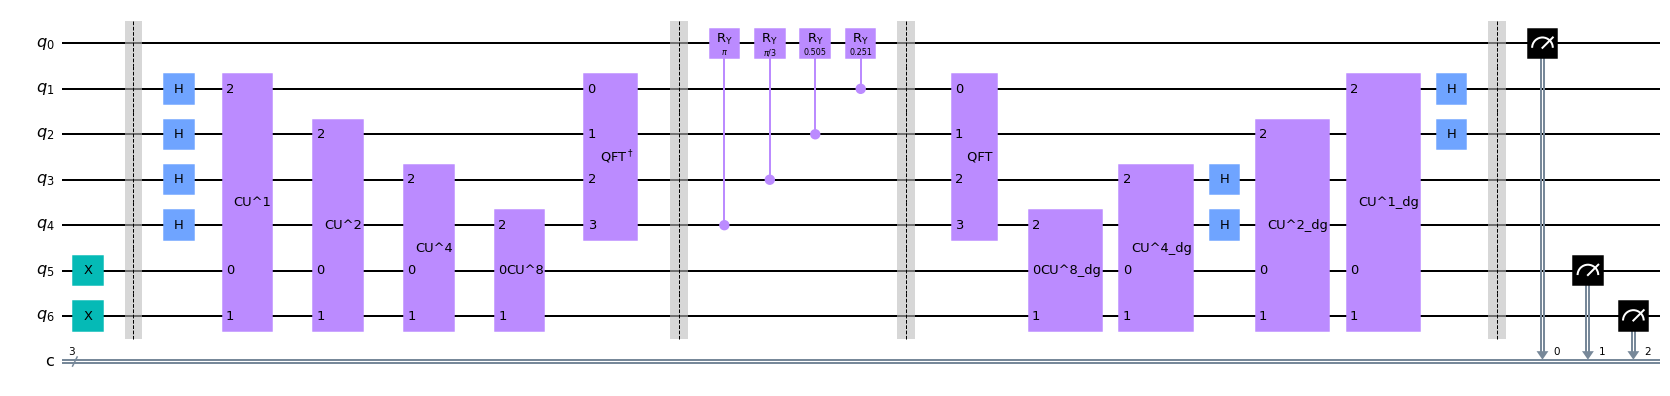

In [7]:
t = (1/8)*np.pi

def CU_test(A,num):

    U_A, C_U = np.eye(4, dtype='complex'), np.eye(8, dtype='complex')
    for i in range(num): U_A = U_A.dot(sp.linalg.expm(1j*A*(1/8)*np.pi))
    C_U[4:8,4:8] = U_A 

    qc = QuantumCircuit(3)
    phase = 0

    if num == 1: phase = CU_12(qc,C_U,range(3),phase)
    if num == 2: phase = CU_12(qc,C_U,range(3),phase)
    if num == 4: phase = CU_3(qc,C_U,range(3),phase)
    if num == 8: phase = CU_4(qc,C_U,range(3),phase)

    global_phase_gate(qc,phase,0)
    
    CU_gate = qc.to_gate()
    CU_gate.name = "CU^{}".format(num)
    
    return CU_gate

qc = QuantumCircuit(7,3)
qc.x([5,6])

qc.barrier()

qc.h([1,2,3,4])

qc.append(CU_test(M,1),[5,6,1])
qc.append(CU_test(M,2),[5,6,2])
qc.append(CU_test(M,4),[5,6,3])
qc.append(CU_test(M,8),[5,6,4])
  
########## reverse without SWAP ##########
qft_dagger(qc,4,[1,2,3,4])
qc.barrier()

qc.cry(2*np.arcsin(1/1),4,0)
qc.cry(2*np.arcsin(1/2),3,0)
qc.cry(2*np.arcsin(1/4),2,0)
qc.cry(2*np.arcsin(1/8),1,0)

qc.barrier()
qft(qc,4,[1,2,3,4])
########## reverse without SWAP ##########

qc.append(CU_test(M,8).inverse(),[5,6,4])
qc.append(CU_test(M,4).inverse(),[5,6,3])
qc.append(CU_test(M,2).inverse(),[5,6,2])
qc.append(CU_test(M,1).inverse(),[5,6,1])

qc.h([1,2,3,4])

qc.save_statevector()
qc.measure([0,5,6],[0,1,2])
print("CNOT counts:", qc.decompose().decompose().decompose().decompose().decompose().count_ops()['cx'])
qc.draw(output="mpl",fold=-1)

In [8]:
result = execute(qc, backend=backend, shots=1024, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[1], sv[33], sv[65], sv[97]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

solution: [-0.09375  0.15625  0.28125  0.46875]


In [9]:
# qc = QuantumCircuit(5)

# qc.append(CU_test(M,1),[0,1,2])
# qc.append(CU_test(M,2),[0,1,2])
# qc.append(CU_test(M,4),[0,1,2])
# qc.append(CU_test(M,8),[0,1,2])

# qft_dagger(qc,4,[1,2,3,4])

# print(np.round(np.matrix(Operator(qc)),3))

# print("CNOT counts:", qc.decompose().decompose().decompose().decompose().decompose().count_ops()['cx'])
# qc.decompose().draw(output="mpl")

Qiskit's built-in HHL

In [10]:
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector

hhl_qc = HHL().construct_circuit(M, b)
hhl_qc.save_statevector()
hhl_qc.measure_all()

result = execute(hhl_qc, backend=backend, shots=4096, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[128], sv[129], sv[130], sv[131]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

hhl_qc.decompose().draw(fold=-1)

solution: [-0.09375  0.15625  0.28125  0.46875]


┌───────────┐┌──────┐        ┌─────────┐ ░  ░ ┌─┐                     
 q49_0: ┤0          ├┤5     ├────────┤5        ├─░──░─┤M├─────────────────────
        │  Isometry ││      │        │         │ ░  ░ └╥┘┌─┐                  
 q49_1: ┤1          ├┤6     ├────────┤6        ├─░──░──╫─┤M├──────────────────
        └───────────┘│      │┌──────┐│         │ ░  ░  ║ └╥┘┌─┐               
 q50_0: ─────────────┤0     ├┤4     ├┤0        ├─░──░──╫──╫─┤M├───────────────
                     │      ││      ││         │ ░  ░  ║  ║ └╥┘┌─┐            
 q50_1: ─────────────┤1 QPE ├┤3     ├┤1 QPE_dg ├─░──░──╫──╫──╫─┤M├────────────
                     │      ││      ││         │ ░  ░  ║  ║  ║ └╥┘┌─┐         
 q50_2: ─────────────┤2     ├┤2     ├┤2        ├─░──░──╫──╫──╫──╫─┤M├─────────
                     │      ││  1/x ││         │ ░  ░  ║  ║  ║  ║ └╥┘┌─┐      
 q50_3: ─────────────┤3     ├┤1     ├┤3        ├─░──░──╫──╫──╫──╫──╫─┤M├──────
                     │      ││      ││         │ ░  ░  ║  ║  ║  ║  ║ └╥┘┌─┐   
 q50_4: ─────────────┤4     ├┤0     ├┤4        ├─░──░──╫──╫──╫──╫──╫──╫─┤M├───
                     └──────┘│      │└─────────┘ ░  ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
   q51: ─────────────────────┤5     ├────────────░──░──╫──╫──╫──╫──╫──╫──╫─┤M├
                             └──────┘            ░  ░  ║  ║  ║  ║  ║  ║  ║ └╥┘
meas: 8/═══════════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                                       0  1  2  3  4  5  6  7

Quite confusing why Qiskit's built-in HHL uses so much CNOTs

In [11]:
print("CNOT counts:", hhl_qc.decompose().decompose().decompose().decompose().count_ops()['cx'])

CNOT counts: 2421
